## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [1]:
import os

model_save_path = "saved_model1"
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI", "INDI", "FOREIGN", "ORG"]
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
cols = ["KOSPI", "KOSPI_START", "KOSPI_HIGH", "KOSPI_LOW", "NASDAQ", "DOW", "CR", "GOLD"]
len_x_ARMA = 60
len_y_nextday = 20
scale_method = "norm"

# 패키지 캐시 모두 지우기 (tf 등 이전에 남은 가비지가 영향을 미칠 수 있음)
for dir_ in ["/Users/hrdkdh/Documents/GitHub/predict/", "/Users/hrdkdh/venv/"]:
    os.system("find {} | grep -E '(__pycache__|\.pyc$|\pyo$)' | xargs rm -rf".format(dir_))

1-1) 데이터 크롤링

In [2]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=30, perPage=100)
crawler.crawlData(cols, save=True)
# crawler.loadFromSavedFile(cols)
df_crawled = crawler.removeNan()
df_crawled = df_crawled.loc[:2000]
df_crawled


KOSPI : 데이터 수집중...
KOSPI_START : 데이터 수집중...
KOSPI_HIGH : 데이터 수집중...
KOSPI_LOW : 데이터 수집중...
NASDAQ : 30번째 페이지 데이터 수집중...
DOW : 30번째 페이지 데이터 수집중...(에러로 재시도1)
CR : 30번째 페이지 데이터 수집중...에러로 재시도1)


,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD
0,2022-04-13,2716.49,2677.53,2717.63,2672.60,13371.572,34220.36,1228.5,1974.18
1,2022-04-12,2666.76,2674.17,2685.08,2658.40,13411.956,34308.08,1232.0,1951.78
2,2022-04-11,2693.10,2687.54,2711.02,2683.96,13710.996,34721.12,1233.5,1957.30
3,2022-04-08,2700.39,2706.64,2712.00,2685.52,13897.300,34583.57,1228.0,1931.56
4,2022-04-07,2695.86,2714.70,2718.50,2693.36,13888.817,34496.51,1220.5,1926.02
...,...,...,...,...,...,...,...,...,...
1996,2014-02-28,1979.99,1976.48,1981.15,1972.65,4318.933,16272.65,1067.7,1327.06
1997,2014-02-27,1978.43,1969.85,1980.37,1965.70,4292.064,16198.41,1067.5,1325.85
1998,2014-02-26,1970.77,1963.45,1973.88,1955.92,4287.588,16179.66,1066.2,1342.45
1999,2014-02-25,1964.86,1958.30,1964.86,1955.70,4292.968,16207.14,1073.2,1337.03


1-2. 데이터 전처리

In [3]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols, scale_method, model_save_path)
dpp.sortByDate()
dpp.makeDiffRatio()
dpp.scalingForModeling()
dpp.makeAR(0, len_x_ARMA)
# dpp.makeMA(2, len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)

자기상관 생성중... (100.00%)



In [4]:
dpp.getRemoveColByRegression(threshold=0.7)
# dpp.remove_cols

In [5]:
#상관계수로 드랍할 변수 선택하기
# dpp.getRemoveColByCorr(threshold=0.7)
# len(dpp.remove_cols)

In [6]:
#변수 선택하고 데이터 분할
dpp.df.drop(columns=dpp.remove_cols, inplace=True)
dpp.splitData()
# dpp.df.to_excel("processed_data.xlsx", index=False)
dpp.df

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD,X_KOSPI_AR0,...,Y_KOSPI_nextday_11,Y_KOSPI_nextday_12,Y_KOSPI_nextday_13,Y_KOSPI_nextday_14,Y_KOSPI_nextday_15,Y_KOSPI_nextday_16,Y_KOSPI_nextday_17,Y_KOSPI_nextday_18,Y_KOSPI_nextday_19,Y_KOSPI_nextday_20
0,2014-05-23,-0.689572,-0.702695,-0.712347,-0.676363,-1.095558,-1.219753,-2.224762,-0.478379,-0.689572,...,-0.696132,-0.704057,-0.758636,-0.751446,-0.730559,-0.762204,-0.755539,-0.818410,-0.800436,-0.749452
1,2014-05-26,-0.707468,-0.694515,-0.704538,-0.685928,-1.090886,-1.214455,-2.244496,-0.479617,-0.707468,...,-0.704057,-0.758636,-0.751446,-0.730559,-0.762204,-0.755539,-0.818410,-0.800436,-0.749452,-0.782462
2,2014-05-27,-0.740845,-0.698028,-0.715549,-0.737984,-1.086213,-1.209158,-2.258310,-0.514541,-0.740845,...,-0.758636,-0.751446,-0.730559,-0.762204,-0.755539,-0.818410,-0.800436,-0.749452,-0.782462,-0.747615
3,2014-05-28,-0.689861,-0.736332,-0.714690,-0.713013,-1.070989,-1.197550,-2.295804,-0.584737,-0.689861,...,-0.751446,-0.730559,-0.762204,-0.755539,-0.818410,-0.800436,-0.749452,-0.782462,-0.747615,-0.764776
4,2014-05-29,-0.702456,-0.682822,-0.701935,-0.683048,-1.074551,-1.204646,-2.353031,-0.629872,-0.702456,...,-0.730559,-0.762204,-0.755539,-0.818410,-0.800436,-0.749452,-0.782462,-0.747615,-0.764776,-0.728827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2022-03-10,1.050533,0.995587,1.018203,1.038831,1.607475,1.587531,1.791032,2.201455,1.050533,...,1.180841,1.179739,1.209941,1.224819,1.253447,1.206740,1.254103,1.257514,1.194092,1.091310
1916,2022-03-11,1.000572,1.008932,0.991731,1.002947,1.570177,1.568722,1.919300,2.232202,1.000572,...,1.179739,1.209941,1.224819,1.253447,1.206740,1.254103,1.257514,1.194092,1.091310,1.103197
1917,2022-03-14,0.959559,0.980041,0.963462,0.966032,1.485189,1.530179,1.998235,2.140657,0.959559,...,1.209941,1.224819,1.253447,1.206740,1.254103,1.257514,1.194092,1.091310,1.103197,1.084068
1918,2022-03-15,0.896268,0.915493,0.911949,0.917861,1.407202,1.530355,2.126504,2.006530,0.896268,...,1.224819,1.253447,1.206740,1.254103,1.257514,1.194092,1.091310,1.103197,1.084068,1.014952


1-3) 모델 훈련하고 생성

2022-04-14 13:47:26.723652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-14 13:47:26.723731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-14 13:47:26.822588: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 546)               0         
                                                                 
 dense (Dense)               (None, 1024)              560128    
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                                 
 dense_2 (Dense)             (None, 1024)              21504     
                                                                 
 dense_3 (Dense)             (None, 20)                20500     
                                                                 
Total params: 622,632
Trainable params: 622,632
Non-trainable params: 0
_______________________________________

2022-04-14 13:47:27.074454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-14 13:47:28.298056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


모델 생성 완료1500/1500(100%) loss : 0.0007, mae : 0.0195, mse : 0.0007 / val_loss : 0.0032, val_mae : 0.0405, val_mse : 0.0032                              


2022-04-14 14:08:39.904544: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료
check point : cp-1271


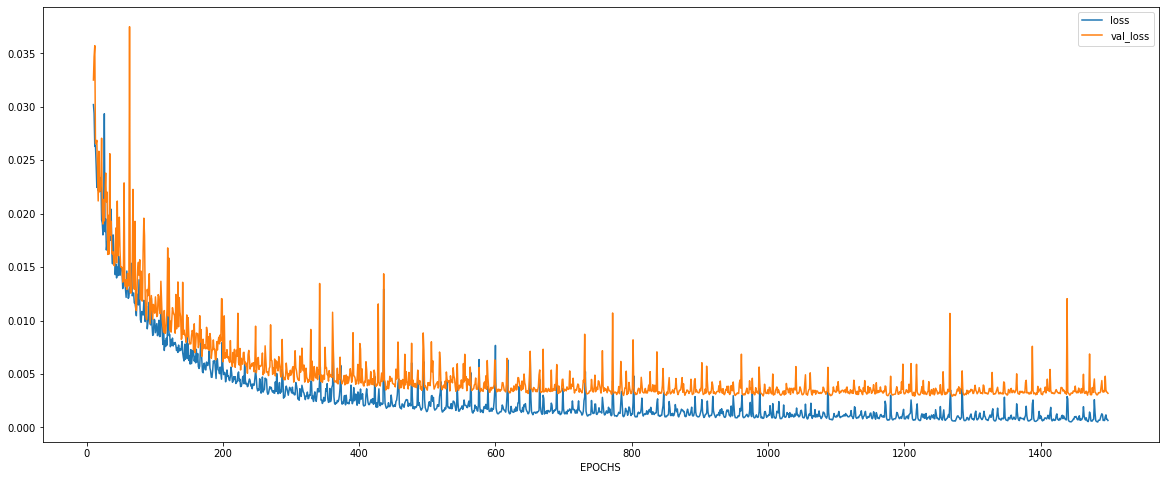

In [7]:
from kospi_predict import ModelMaker

maker = ModelMaker(
    dpp.y_list,
    dpp.df_train,
    dpp.df_test,
    perceptron_vol = 1024,
    dense_vol1 = 1,
    dense_vol2 = 1,
    activation_method = "relu",
    optimizer_str = "Adam",
    model_save_path = model_save_path)
maker.makeModel(EPOCHS=1500, batch_size=8, learning_rate=0.0001, save_by_checkpoint=True)

INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료
check point : cp-1271


,y_no,test_mae,test_mse
0,0,0.042344,0.003609
1,1,0.038829,0.002837
2,2,0.038890,0.002846
3,3,0.036844,0.002701
4,4,0.039183,0.002818
5,5,0.039190,0.003271
6,6,0.036919,0.002483
7,7,0.037765,0.002679
8,8,0.038961,0.003115
9,9,0.036987,0.002570


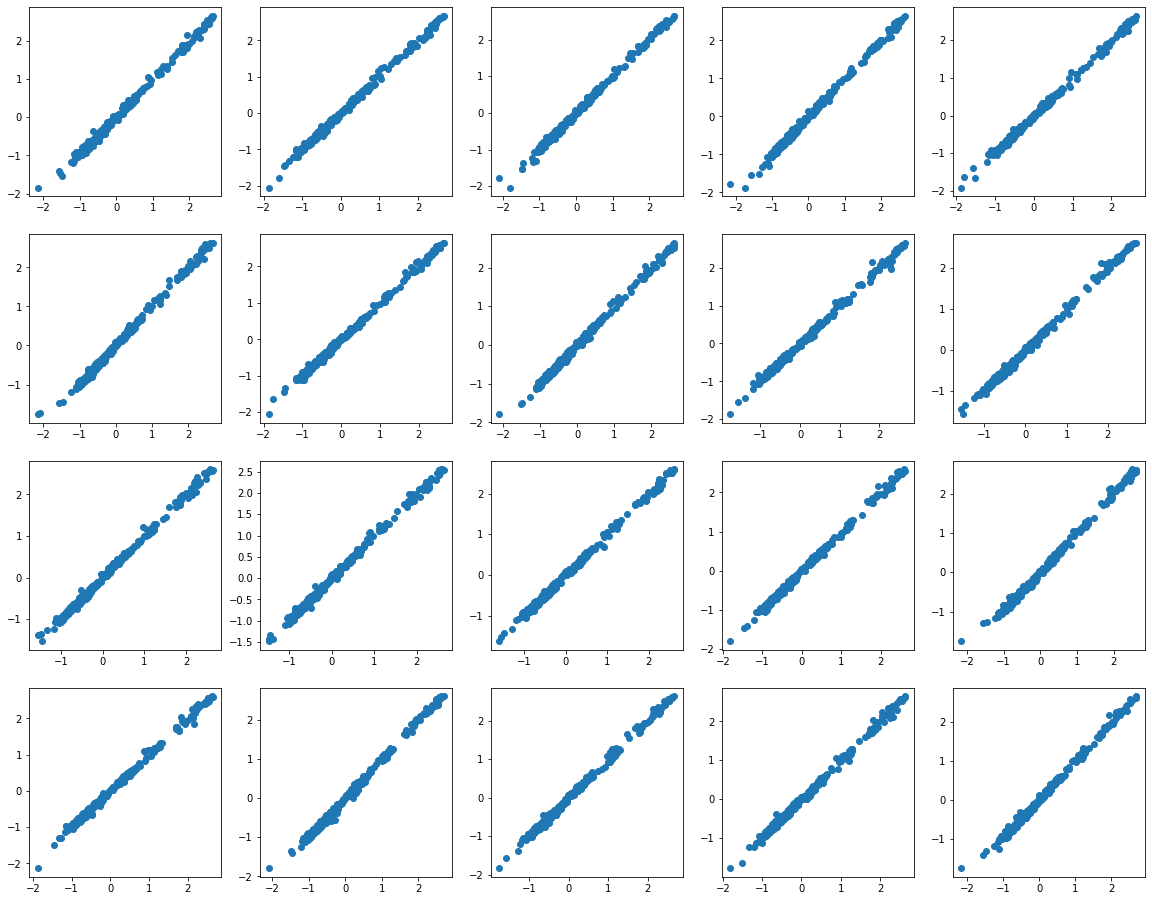

In [32]:
maker.saveModelByCheckpoint(-1)
maker.validateModel()
maker.test_error

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [33]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=100) #이전 추세도 볼겸 넉넉히 수집
crawler_pred.crawlData(cols)
df_crawled_pred = crawler_pred.removeNan()
df_crawled_pred


KOSPI : 데이터 수집중...
KOSPI_START : 데이터 수집중...
KOSPI_HIGH : 데이터 수집중...
KOSPI_LOW : 데이터 수집중...
NASDAQ : 1번째 페이지 데이터 수집중...
DOW : 1번째 페이지 데이터 수집중...
CR : 1번째 페이지 데이터 수집중...


,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,NASDAQ,DOW,CR,GOLD
0,2022-04-13,2716.49,2677.53,2717.63,2672.60,13371.572,34220.36,1228.5,1974.18
1,2022-04-12,2666.76,2674.17,2685.08,2658.40,13411.956,34308.08,1232.0,1951.78
2,2022-04-11,2693.10,2687.54,2711.02,2683.96,13710.996,34721.12,1233.5,1957.30
3,2022-04-08,2700.39,2706.64,2712.00,2685.52,13897.300,34583.57,1228.0,1931.56
4,2022-04-07,2695.86,2714.70,2718.50,2693.36,13888.817,34496.51,1220.5,1926.02
...,...,...,...,...,...,...,...,...,...
87,2021-12-03,2968.33,2935.93,2975.44,2927.55,15381.320,34639.79,1183.0,1769.72
88,2021-12-02,2945.27,2874.64,2945.27,2874.64,15254.052,34022.04,1177.0,1770.45
89,2021-12-01,2899.72,2860.12,2905.74,2837.03,15537.691,34483.72,1180.5,1778.45
90,2021-11-30,2839.01,2932.71,2942.93,2822.73,15782.834,35135.94,1190.0,1793.05


2-2) 데이터 전처리

In [34]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred.loc[:100], cols, scale_method, model_save_path)
dpp_pred.sortByDate()
dpp_pred.makeDiffRatio()
dpp_pred.scalingForPredict()
dpp_pred.makeAR(0, len_x_ARMA)
# dpp_pred.makeMA(2, len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

자기상관 생성중... (100.00%)



2-3) 예측

2022-04-14 14:10:53.767105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


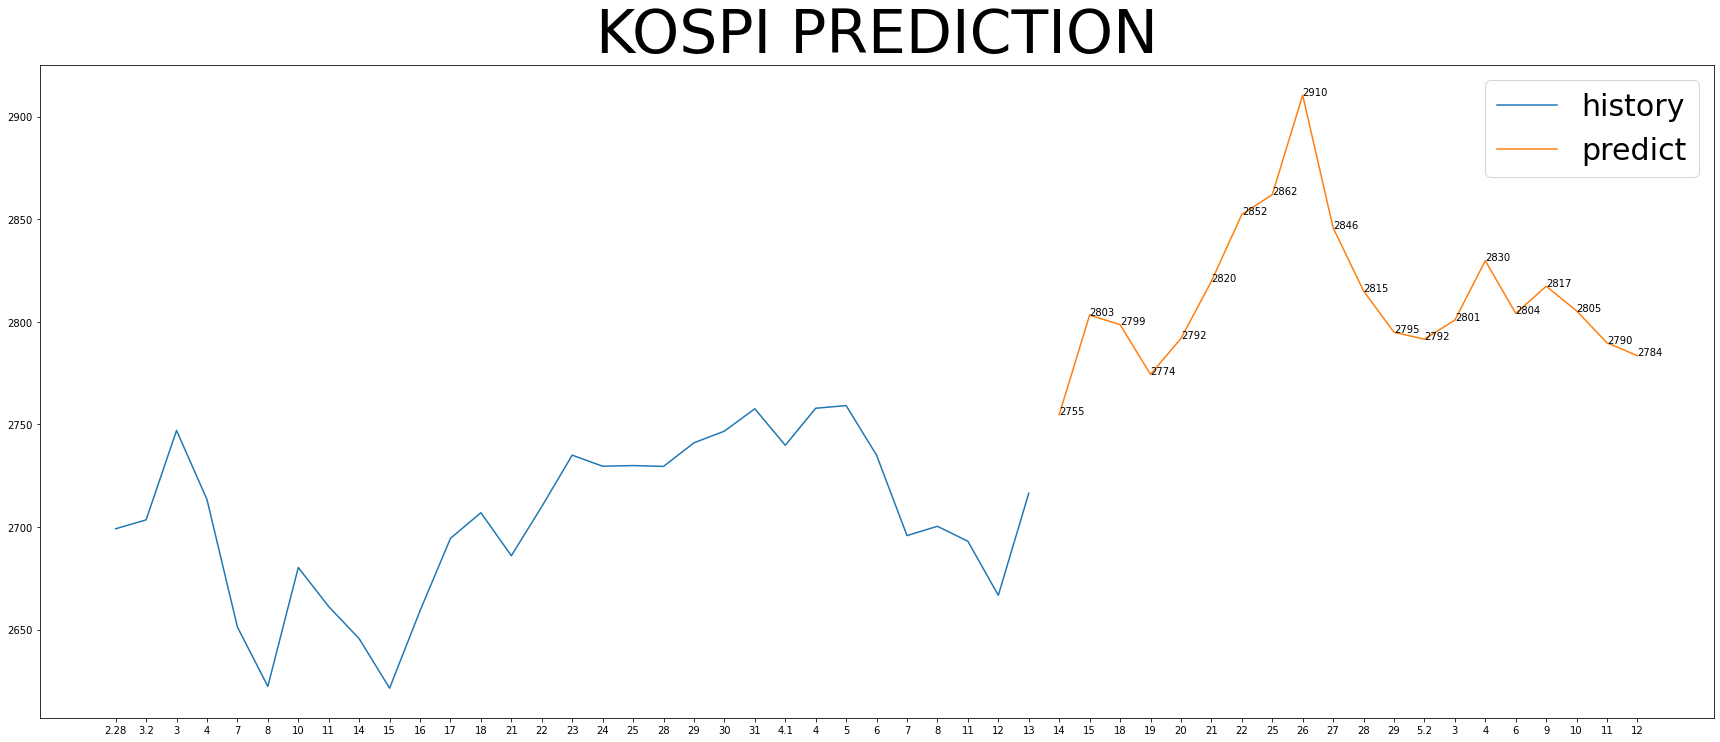

In [35]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df, scale_method = scale_method, model_save_path=model_save_path)
predictor.predict()
predictor.showPredictionPlot()

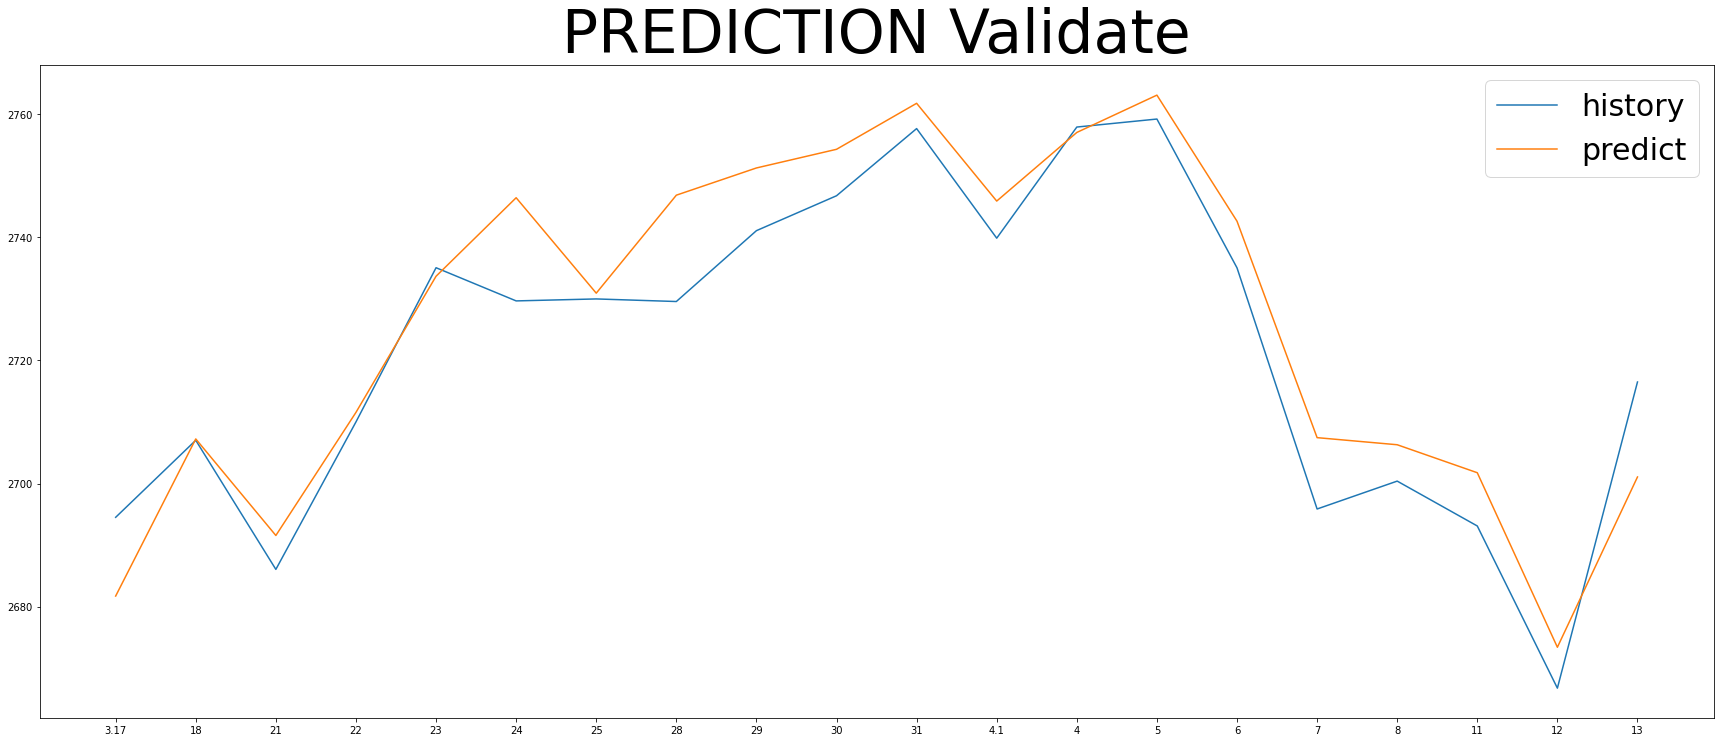

In [36]:
#실제 기록과 예측값을 비교하여 예측이 얼마나 잘 맞는지 확인한다
history_before = 21
df_result = predictor.predict(history_before)
predictor.showPredictionByHistory(df_result, history_before)

In [37]:
len(predictor.x_cols)
predictor.saveModelToJS()